### Description

This notebook contains the Python implementation of the rules of the Trend Following strategy by Carlo Zarattini et al.

We will take a couple of the examples presented in the paper (charts for NOC and LLY) and test the strategy on them, while validating the correctness of the formulas (Trailing Stop and ATH), along with the timings of the entries and exits.

Source : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5084316

### Libraries and Data

In [129]:
import pandas as pd
import talib
import vectorbt as vbt
import yfinance as yf
from tqdm import tqdm
import empyrical as ep
import numpy as np
import matplotlib.pyplot as plt

### Implementation

Rules

- Go long (on close) if the daily high is equal or higher than the All Time High (ATH).
- Exit long (on close) using a Trailing Stop, as Trailing Stop = ATH x (1 - ATR / ATH) ^ 10


##### The NOC example

In [117]:
# Load NOC data
stocks_data = yf.download(['NOC'], period='max')

# Compute indicators
ath = stocks_data.High.cummax()  # All-time high based on High price

atr = talib.ATR(stocks_data.High, stocks_data.Low, stocks_data['Close'], timeperiod=42)

# Compute trailing stop
trailing_stop = ath * (1 - atr / ath) ** 10
trailing_stop = trailing_stop.cummax()  # Ensure trailing stop never decreases

# Compute entries and exits
entries = stocks_data.High >= ath.shift()  # Entry on High >= previous ATH
exits = stocks_data.Close <= trailing_stop  # Exit when Adj Close <= trailing stop

# Running the backtest
pf = vbt.Portfolio.from_signals(
    stocks_data.Close, 
    entries, 
    exits
)

[*********************100%%**********************]  1 of 1 completed


In [124]:
# Print the trades
pf.trades.records_readable


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,13.348424,1982-02-03,7.491521,0.0,1982-03-09,6.437438,0.0,-14.070345,-0.140703,Long,Closed,0
1,1,0,10.666266,1982-05-05,8.056208,0.0,1982-06-29,6.588021,0.0,-15.660072,-0.182243,Long,Closed,1
2,2,0,8.702082,1982-07-22,8.075031,0.0,1982-11-12,9.260875,0.0,10.319307,0.146853,Long,Closed,2
3,3,0,6.861257,1983-01-14,11.745500,0.0,1983-04-07,10.013792,0.0,-11.881690,-0.147436,Long,Closed,3
4,4,0,5.667995,1983-04-21,12.121958,0.0,1983-07-18,12.573708,0.0,2.560516,0.037267,Long,Closed,4
5,5,0,4.866608,1983-07-26,14.644229,0.0,1983-08-25,12.385479,0.0,-10.992450,-0.154242,Long,Closed,5
6,6,0,4.068904,1984-08-02,14.813635,0.0,1984-09-26,15.303031,0.0,1.991306,0.033037,Long,Closed,6
7,7,0,3.435119,1985-02-14,18.126469,0.0,1985-09-25,21.232250,0.0,10.668728,0.171340,Long,Closed,7
8,8,0,2.844944,1995-07-25,25.636812,0.0,1995-10-25,25.298000,0.0,-0.963901,-0.013216,Long,Closed,8
9,9,0,2.538914,1995-12-05,28.347313,0.0,1996-04-11,26.653250,0.0,-4.301081,-0.059761,Long,Closed,9


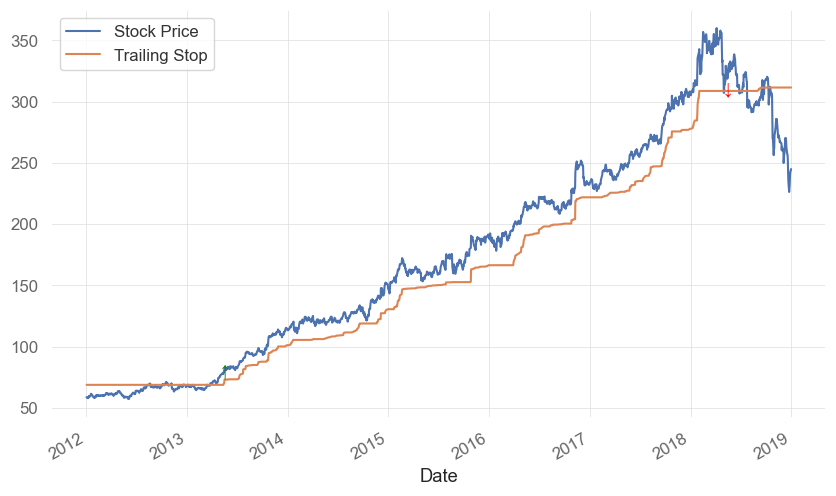

In [122]:
# Replicating the paper's chart
fig, ax = plt.subplots(figsize=(10, 6))
stocks_data['Close'].loc['2012':'2018'].plot(label='Stock Price', ax=ax)
trailing_stop.loc['2012':'2018'].plot(label='Trailing Stop', ax=ax)

# Add arrows for entries and exits
entry_date = '2013-05-03'
price = stocks_data['Close'].loc[entry_date]
ax.annotate('↑', xy=(entry_date, price), color='green', fontsize=12)

exit_date = '2018-05-01'
price = stocks_data['Close'].loc[exit_date]
ax.annotate('↓', xy=(exit_date, price), color='red', fontsize=12)

plt.legend()
plt.show()

##### The LLY example


In [125]:
# Load NOC data
stocks_data = yf.download(['LLY'], period='max')

# Compute indicators
ath = stocks_data.High.cummax()  # All-time high based on High price

atr = talib.ATR(stocks_data.High, stocks_data.Low, stocks_data['Close'], timeperiod=42)

# Compute trailing stop
trailing_stop = ath * (1 - atr / ath) ** 10
trailing_stop = trailing_stop.cummax()  # Ensure trailing stop never decreases

# Compute entries and exits
entries = stocks_data.High >= ath.shift()  # Entry on High >= previous ATH
exits = stocks_data.Close <= trailing_stop  # Exit when Adj Close <= trailing stop

# Running the backtest
pf = vbt.Portfolio.from_signals(
    stocks_data.Close, 
    entries, 
    exits
)

[*********************100%%**********************]  1 of 1 completed


In [127]:
# Print the trades
pf.trades.records_readable


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,24.427481,1972-06-02,4.093750,0.0,1973-08-20,4.843750,0.0,18.320611,0.183206,Long,Closed,0
1,1,0,20.411103,1985-10-23,5.796875,0.0,1986-09-11,8.390625,0.0,52.941298,0.447439,Long,Closed,1
2,2,0,16.457601,1987-01-22,10.406250,0.0,1987-05-19,10.421875,0.0,0.257150,0.001502,Long,Closed,2
3,3,0,13.452475,1987-08-11,12.750000,0.0,1987-10-15,10.703125,0.0,-27.535535,-0.160539,Long,Closed,3
4,4,0,10.519344,1989-04-25,13.687500,0.0,1990-08-07,18.937500,0.0,55.226557,0.383562,Long,Closed,4
5,5,0,8.853781,1995-09-21,22.500000,0.0,1999-04-19,72.875000,0.0,446.009235,2.238889,Long,Closed,5
6,6,0,6.349022,2000-06-29,101.625000,0.0,2000-08-09,76.875000,0.0,-157.138283,-0.243542,Long,Closed,6
7,7,0,4.493473,2018-10-03,108.620003,0.0,2019-06-13,111.820000,0.0,14.379099,0.029460,Long,Closed,7
8,8,0,3.794157,2019-12-20,132.429993,0.0,2020-02-28,126.129997,0.0,-23.903169,-0.047572,Long,Closed,8
9,9,0,3.166944,2020-04-14,151.110001,0.0,2020-10-27,131.899994,0.0,-60.837022,-0.127126,Long,Closed,9


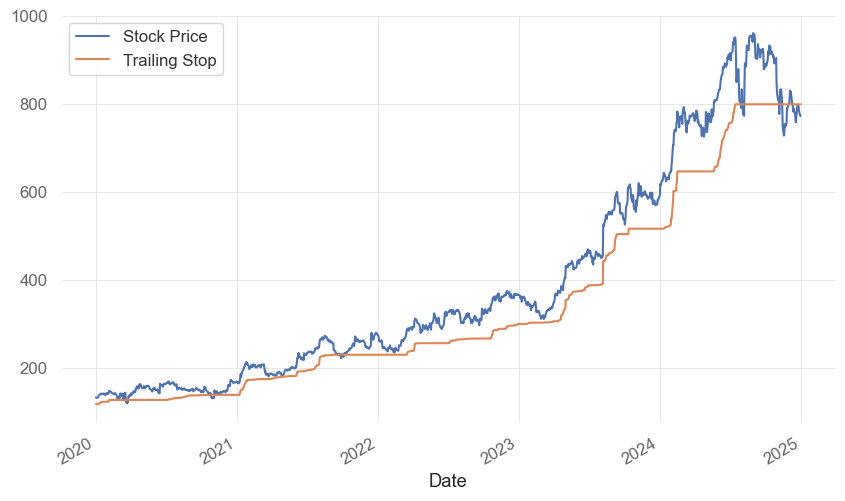

In [128]:
# Replicating the paper's chart
fig, ax = plt.subplots(figsize=(10, 6))
stocks_data['Close'].loc['2020':'2024'].plot(label='Stock Price', ax=ax)
trailing_stop.loc['2020':'2024'].plot(label='Trailing Stop', ax=ax)

plt.legend()
plt.show()

### Conclusion and Next Steps

It appears that the implementation of the indicators is correct, as the charts of both examples match the ones presented in the paper. It needs to be noted though that they are not identical, and this is likely due to the fact that we're using a different data provided (Yahoo Finance instead of Norgate), along with the fact that in our case the data is not adjusted for splits and dividends.

Next Steps:

- Use a similar, adjusted dataset (ideally from Norgate)
- Define the Universe, as the paper mentions (closing price > $10, Average dollar volume over the last 42 trading days above $1,000,000, etc.)
- Simulate the Portfolio strategy, taking all trades occuring in the defined Universe
- Incorporate a transaction cost of 0.50% per round turn to account for slippage and commissions (as noted in the paper)
- Replicate the final Equity Curve chart and compare it with the one presented in the paper
